# Mushroom Classification - AI Essentials 2025 Assignment

![Mushrooms](../src/mushrooms.png)

## Basic Information

### Author: Juan Benjumea Moreno

### Assignment:  
Predict whether a mushroom is **poisonous** or **edible**.

### Parameters:  
Classification Mushroom Data 2020: improvement and extension of the UC Irvine 1987 Mushroom Data Set.  

Physical characteristics. The dataset is provided in the accompanying file 'mushroom.csv'. A full description of the dataset can be found in the file 'metadata.txt'. Primary data contains 173 mushroom species, secondary data 61069 hypothetical mushrooms based on those species. 20 features, three quantitative and 17 categorical, 2 classes (poisonous or edible).

### Basic requirements:
- Define the problem, analyze the data, and prepare the data for your model.
- Train at least 3 models (e.g., decision trees, nearest neighbour, ...) to predict whether a mushroom is poisonous or edible. Motivate choices.
- Optimize the model parameters settings.
- Compare the best parameter settings for the models and estimate their errors on unseen data. Investigate the learning process critically (overfitting/underfitting). 

### Optional extensions:
- Build and host an API for your best performing model.
- Try to combine multiple models.
- Investigate whether all features are necessary to produce a good model.

### Approach

1. Imports, Exploratory Data Analysis and Preprocessing
2. Create helper functions: pipeline creation, grid search, and learning curve
3. Train, tune and evaluate models
4. Extra analysis: feature selection and model combination
4. Conclusions

## 1. Imports, Preprocessing and Exploratory Data Analysis

In [1]:
%uv pip install -r requirements.txt
# % pip install -r requirements.txt if not %uv

/Users/juanbenjumea/Coding/Projects/mushroom-ai/.venv/bin/python: No module named uv
Note: you may need to restart the kernel to use updated packages.


In [2]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import time
from scipy.stats import uniform, loguniform, randint

# preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# classifiers
from sklearn.linear_model import LogisticRegression as lr, SGDClassifier as sgd

from sklearn.ensemble import RandomForestClassifier as rf, ExtraTreesClassifier as et

import xgboost as xgb
from catboost import CatBoostClassifier as cb

# hyperparameter tuning en model evaluatie
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.metrics import accuracy_score

# ensembles en feature selection
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [3]:
# import the data
mushroom = pd.read_csv("../src/mushroom.csv", sep=";")

### 1.1. Basic data cleanup

In [4]:
mushroom.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


#### Change class to 0 and 1
Change the class values to 0 (edible) and 1 (poisonous)

In [5]:
mushroom["class"] = mushroom["class"].map({"e": 0, "p": 1})

In [6]:
mushroom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  int64  
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

#### Adapt object columns to categorical for better performance

In [7]:
feature_cols = mushroom.columns.drop("class")
# convert object columns to categorical
categorical_columns = mushroom.select_dtypes(include=["object"]).columns
mushroom[categorical_columns] = mushroom[categorical_columns].apply(
    lambda col: col.astype("category")
)

In [8]:
# missing values
mushroom.isnull().sum()

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

#### Drop columns with > 60% null values

In [9]:
# Establish thresholds for different data quality scenarios
high_quality_threshold = 0.3 
standard_threshold = 0.6  
permissive_threshold = 0.8

# In this run I'll use a standad threshold
missing_threshold = standard_threshold  # Currently using 60%
missing_percentage = mushroom.isnull().sum() / len(mushroom)

# Find columns with more than 60% missing values
cols_to_drop = missing_percentage[missing_percentage > missing_threshold].index.tolist()

# Remove 'class' column from drop list if it's there (we need the target variable)
if "class" in cols_to_drop:
    cols_to_drop.remove("class")

if cols_to_drop:
    print(f"Columns with > {missing_threshold * 100}% missing values:")
    for col in cols_to_drop:
        print(f"  - {col}: {missing_percentage[col] * 100:.1f}% missing")
        
    # Save dropped columns info
    dropped_cols_info = {
        "columns": cols_to_drop,
        "missing_percentages": {
            col: missing_percentage[col] * 100 for col in cols_to_drop
        },
        "threshold_used": missing_threshold * 100,
        "drop_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    }

    # Actually drop columns
    mushroom = mushroom.drop(columns=cols_to_drop)

    print(f"\nDropped {len(cols_to_drop)} columns: {cols_to_drop}")
    print(f"Dataset shape after dropping columns: {mushroom.shape}")
else:
    print(f"No columns found with > {missing_threshold * 100}% missing values")
    print(f"Dataset shape remains: {mushroom.shape}")

with open("../logs/dropped_cols_info.json", "w") as f:
    json.dump(dropped_cols_info, f, indent=4)

# Generate data quality report
print("\n=== Data Quality Report ===")
print(f"Total columns: {len(mushroom.columns)}")
print(f"Columns with no missing values: {(missing_percentage == 0).sum()}")
print(f"Columns with < 10% missing: {(missing_percentage < 0.1).sum()}")
print(
    f"Columns with 10-30% missing: {((missing_percentage >= 0.1) & (missing_percentage < 0.3)).sum()}"
)
print(
    f"Columns with 30-60% missing: {((missing_percentage >= 0.3) & (missing_percentage < 0.6)).sum()}"
)
print(f"Columns with > 60% missing: {(missing_percentage >= 0.6).sum()}")

Columns with > 60.0% missing values:
  - stem-root: 84.4% missing
  - stem-surface: 62.4% missing
  - veil-type: 94.8% missing
  - veil-color: 87.9% missing
  - spore-print-color: 89.6% missing

Dropped 5 columns: ['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color']
Dataset shape after dropping columns: (61069, 16)

=== Data Quality Report ===
Total columns: 16
Columns with no missing values: 12
Columns with < 10% missing: 13
Columns with 10-30% missing: 2
Columns with 30-60% missing: 1
Columns with > 60% missing: 5


In [10]:
# statistics voor numerische kolommen
mushroom.describe()

,class,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000,61069.000000
mean,0.554913,6.733854,6.581538,12.149410
std,0.496979,5.264845,3.370017,10.035955
min,0.000000,0.380000,0.000000,0.000000
25%,0.000000,3.480000,4.640000,5.210000
50%,1.000000,5.860000,5.950000,10.190000
75%,1.000000,8.540000,7.740000,16.570000
max,1.000000,62.340000,33.920000,103.910000


In [11]:
# Count of zeros in each column
zero_counts = (mushroom[["cap-diameter", "stem-height", "stem-width"]] == 0).sum()
print(zero_counts / len(mushroom) * 100)

cap-diameter    0.000000
stem-height     1.734104
stem-width      1.734104
dtype: float64


#### Drop rows with null values for stem height and width

In [12]:
# 0 hoogte en breedte kan niet dus droppen van de dataset
initial_shape = mushroom.shape
mushroom = mushroom[(mushroom["stem-height"] != 0) & (mushroom["stem-width"] != 0)]
final_shape = mushroom.shape

# Record metadata about the operation
drop_zeros_info = {
    "initial_rows": initial_shape[0],
    "final_rows": final_shape[0],
    "rows_dropped": initial_shape[0] - final_shape[0],
    "reason": "Rows with stem-height or stem-width equal to 0 were dropped.",
    "operation_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
}

# Save metadata to JSON
with open("../logs/drop_zeros_info.json", "w") as f:
    json.dump(drop_zeros_info, f, indent=4)

print(mushroom.shape)

(60010, 16)


### 1.2. Exploratory Data Analysis

In [13]:
feature_cols = mushroom.columns.drop("class")
numerical_cols = [col for col in feature_cols if mushroom[col].dtype == "float64"]
categorical_cols = [col for col in feature_cols if mushroom[col].dtype == "category"]

#### Correlation analysis between numerical features

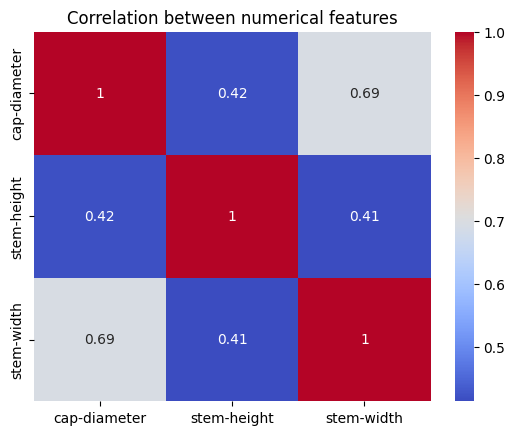

In [14]:
corr_matrix = mushroom[numerical_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation between numerical features")
plt.show()

Conclusion: interesting correlation between cap-diameter and stem width, might be interesting for feature engineering.

#### Class distribution

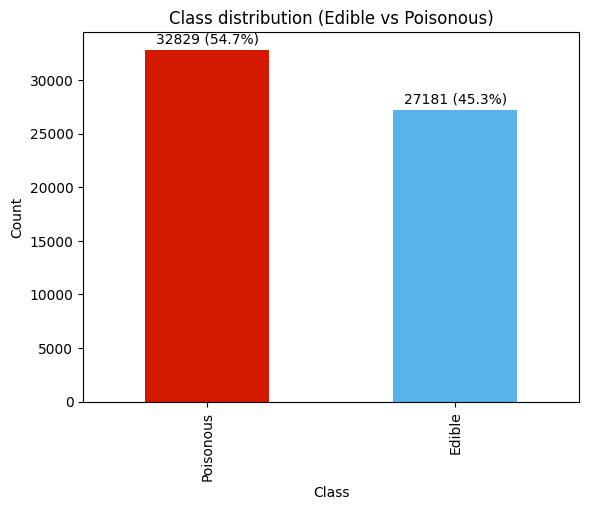

In [15]:
# balance between edible and poisonous mushrooms
counts = mushroom["class"].value_counts()
percentages = counts / counts.sum() * 100

colors = ["#56B4E9" if x == 0 else "#D51900" for x in counts.index]

label_map = {0: "Edible", 1: "Poisonous"}
labels = [label_map[x] for x in counts.index]

ax = counts.plot(
    kind="bar", title="Class distribution (Edible vs Poisonous)", color=colors
)

ax.set_xticklabels(labels)

for i, (v, p) in enumerate(zip(counts, percentages)):
    ax.text(i, v + counts.max() * 0.01, f"{v} ({p:.1f}%)", ha="center", va="bottom")

plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Balanced class distribution, no oversampling needed.

#### Analysis of categorical features to assess their importance

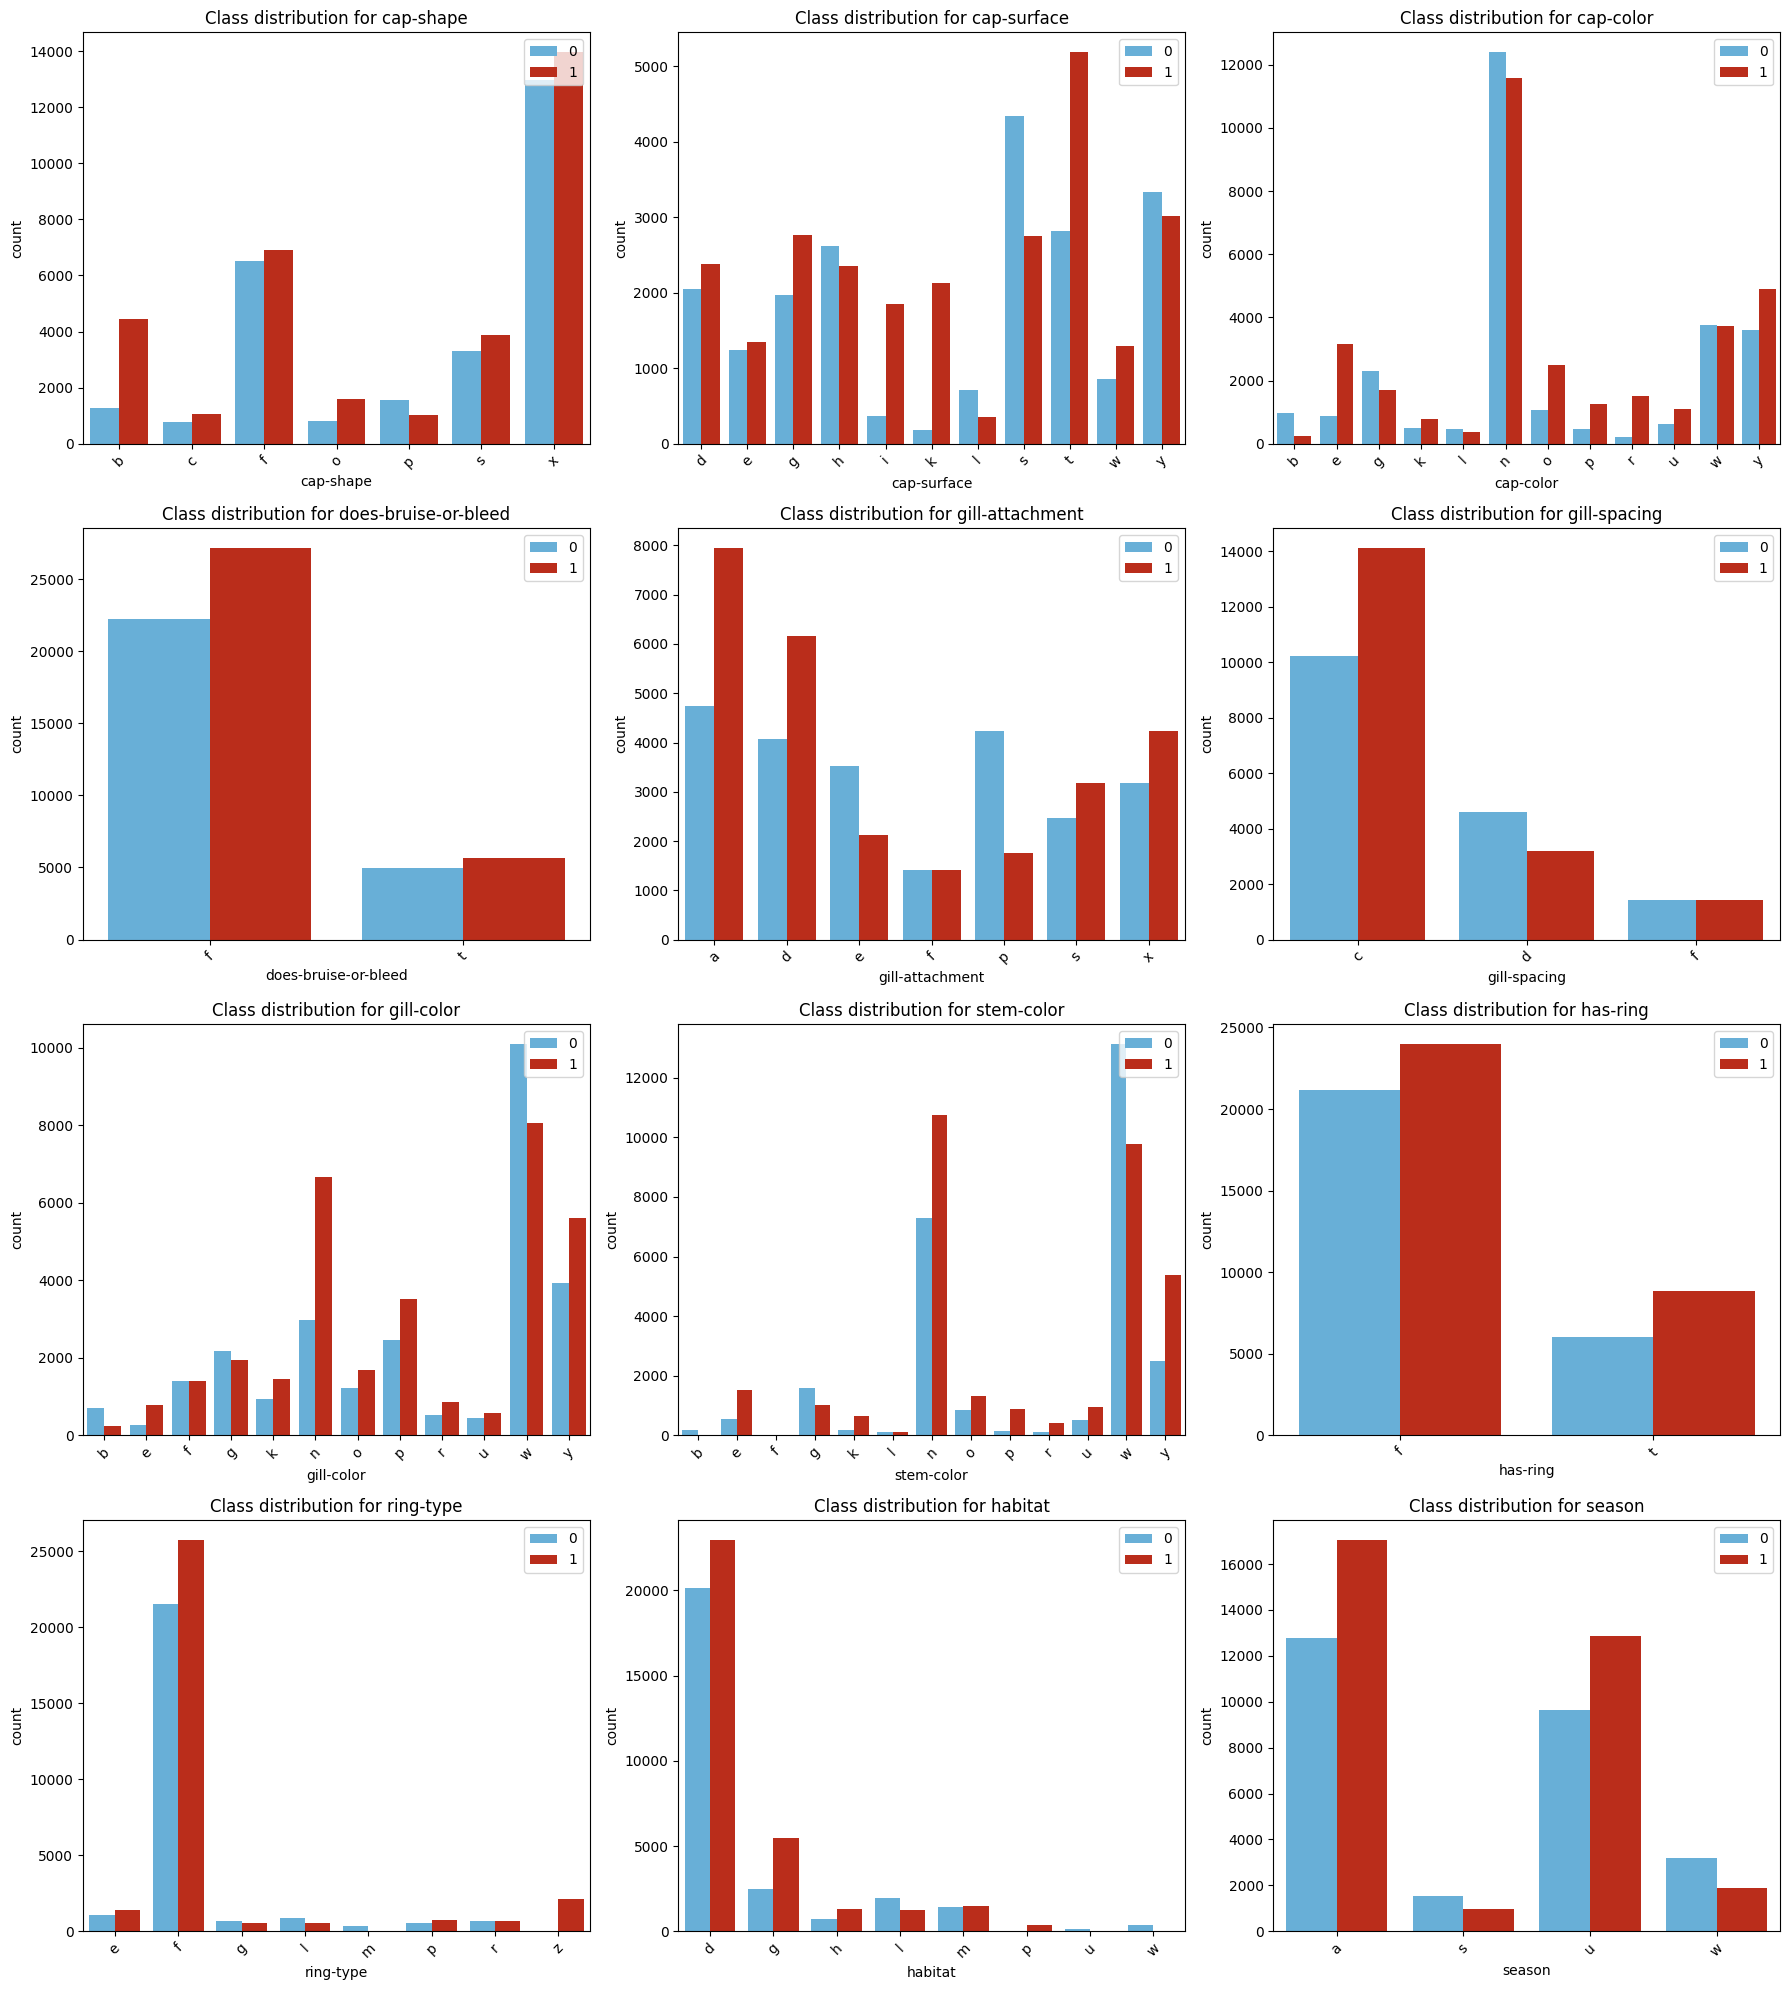

In [16]:
# categorische kolommen plotten om idee te hebben van feature importance
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

palette = ["#56B4E9", "#D51900"]

for i, col in enumerate(categorical_cols):
    sns.countplot(data=mushroom, x=col, hue="class", palette=palette, ax=axes[i])
    axes[i].set_title(f"Class distribution for {col}")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend(loc="upper right")
plt.tight_layout()
plt.show()

**Intermediate Conclusion**

Two useful points to investigate:

1. **Class imbalance across categories**  
   Some categorical features show class imbalance across their categories — e.g. *gill attachment*, *gill spacing*, *gill color*, and *cap surface*. These could be strong predictors.

2. **Category imbalance within certain features**  
   Some categories contain very few samples — e.g. in *ring type*, *habitat*, *stem color*, or *cap color*. Grouping categories might be advisable. In some features, a single category dominates nearly all samples — does this still hold predictive value?

It is advisable to perform a few basic statistical analyses to further explore these aspects. We will do this using two metrics:

- **Weighted class imbalance per feature** — *weighted average class separation*  
- **Category imbalance within features** — *category Gini coefficient*

In [17]:
def gini(array):
    """Compute Gini coefficient of array of counts."""
    array = np.array(array, dtype=np.float64)
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)  # Values cannot be negative
    array += 1e-9  # Prevent division by zero if array sums to zero
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))

In [18]:
dominance_summary = {}

for col in categorical_cols:
    # groeperen per categorie en klasse => aantal voor elke combinatie
    counts = (
        mushroom.groupby([col, "class"], observed=True).size().unstack(fill_value=0)
    )
    # aantal samples per categorie
    category_counts = counts.sum(axis=1)

    class_proportions = counts.div(
        counts.sum(axis=1), axis=0
    )  # normalize per row (category)
    max_percent_per_category = class_proportions.max(axis=1)  # max class % per category

    # Weighted average class (weighted by category size)
    weighted_avg_class_separation = (
        max_percent_per_category * category_counts / category_counts.sum()
    ).sum()

    # Gini of category sizes (imbalance between categories)
    category_gini = gini(category_counts.values)

    dominance_summary[col] = {
        "weighted_avg_class_separation": weighted_avg_class_separation,
        "category_gini": category_gini,
    }

dominance_df = pd.DataFrame(dominance_summary).T
dominance_df = dominance_df.sort_values(
    by="weighted_avg_class_separation", ascending=False
)

pd.set_option("display.max_rows", None)  # if you want to show all features
print(dominance_df)

                      weighted_avg_class_separation  category_gini
stem-color                                 0.615297       0.659707
cap-surface                                0.608760       0.294534
gill-attachment                            0.608392       0.229714
gill-color                                 0.592785       0.492343
cap-color                                  0.584519       0.532956
season                                     0.578287       0.414023
gill-spacing                               0.575758       0.410774
ring-type                                  0.566955       0.732557
habitat                                    0.566656       0.726000
cap-shape                                  0.555991       0.485295
does-bruise-or-bleed                       0.547059       0.323529
has-ring                                   0.547059       0.252941


#### Conclusion:

- Only in **stem color**, **cap surface**, and **gill attachment** is there a clear class imbalance within the categories.

- **Ring type**, **habitat**, and **stem color** are dominated by a few categories; grouping might be advisable.

A process_features helper function is created with a .6 threshold for weighted average class separation and a .65 for gini imbalance between categories. It'll be kept in a json for later use in optimization if needed. 

In [19]:
def process_features(dominance_df, drop_threshold=0.60, group_threshold=0.65):
    """
    Automates the process of dropping features and grouping rare categories
    based on thresholds for weighted_avg_class_separation and category_gini.
    """
    # Features to drop
    features_to_drop = dominance_df[
        dominance_df["weighted_avg_class_separation"] < drop_threshold
    ].index.tolist()

    # Features to group rare categories
    features_to_group_rare = dominance_df[
        dominance_df["category_gini"] > group_threshold
    ].index.tolist()

    return features_to_drop, features_to_group_rare

In [20]:
# Apply the process
features_to_drop, features_to_group_rare = process_features(dominance_df)
feature_optimization = {
    "features_to_drop": features_to_drop,
    "features_to_group_rare": features_to_group_rare,
}

with open("../logs/feature_optimization.json", "w") as f:
    json.dump(feature_optimization, f, indent=4)

print("Features identified for future optimization:")
print(f"  - Features to drop: {features_to_drop}")
print(f"  - Features to group rare: {features_to_group_rare}")

Features identified for future optimization:
  - Features to drop: ['gill-color', 'cap-color', 'season', 'gill-spacing', 'ring-type', 'habitat', 'cap-shape', 'does-bruise-or-bleed', 'has-ring']
  - Features to group rare: ['stem-color', 'ring-type', 'habitat']


**Grouping of rare categories**

In [21]:
# Group rare categories
grouped_info = {}
for feature in features_to_group_rare:
    value_counts = mushroom[feature].value_counts()
    rare_categories = value_counts[
        value_counts < (0.07 * len(mushroom))
    ].index  # Threshold: <7% of total samples

    # Update categories for categorical columns
    if isinstance(mushroom[feature].dtype, pd.CategoricalDtype):
        new_categories = mushroom[feature].cat.categories.tolist()
        # Replace rare categories with "Rare"
        new_categories = [
            "Rare" if category in rare_categories else category
            for category in new_categories
        ]
        # Ensure categories are unique
        new_categories = list(set(new_categories))  # Remove duplicates
        mushroom[feature] = mushroom[feature].cat.set_categories(new_categories)
    else:
        mushroom[feature] = mushroom[feature].replace(rare_categories, "Rare")

    grouped_info[feature] = {
        "rare_categories": list(rare_categories),
        "threshold_percentage": 5,
        "total_samples": len(mushroom),
    }

# Save metadata to JSON
with open("../logs/grouped_rare_categories.json", "w") as f:
    json.dump(grouped_info, f, indent=4)

print(f"Grouped rare categories for features: {features_to_group_rare}")

Grouped rare categories for features: ['stem-color', 'ring-type', 'habitat']


### 1.3 Train/Test Split 

In [22]:
# splitsen in features en target
feature_cols = [col for col in mushroom.columns if col != "class"]

X = mushroom[feature_cols]
y = mushroom["class"]

# splitsen in train en test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#### Save to json for later usage in the api

In [23]:
columns_used = X_train.columns.tolist()

# Save to a JSON file
with open("../api/models/columns_used.json", "w") as f:
    json.dump(columns_used, f)
    
columns_types = {}

for col in numerical_cols:
    columns_types[col] = "float"

for col in categorical_cols:
    columns_types[col] = "str"

# Save columns_types.json
with open("../api/models/columns_types.json", "w") as f:
    json.dump(columns_types, f, indent=2)
    

## 2. Helper Functions: Pipeline Creation, Grid Search, and Learning Curve

To make the notebook modular and easier to maintain, I implemented reusable functions for:
- Pipeline creation: 
    - scaling numerical features
    - imputation & encoding for categorical features
    - optional pca for dimensionality reduction
    - optional kbest feature selection for later optimization
    - classifier usage.
- Hyperparameter tuning (RandomizedSearchCV)
- Learning curve plotting to check for underfitting / overfitting

In [24]:
def create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier,
    encoder_type="onehot",
    use_pca=False,
    n_components=None,
    feature_selector=None,
    selector_params=None,
    random_state=42,
    verbose=False,
):
    """
    Builds a reusable sklearn Pipeline for preprocessing and classification.

    The pipeline applies the following steps:
    - Standard scaling for numerical features.
    - Imputation + encoding of categorical features (OneHot or Ordinal).
    - Optional PCA for dimensionality reduction.
    - Final classification using the specified classifier.
    """
    if verbose:
        print("Creating pipeline with the following configuration:")

    # Validate encoder type
    if encoder_type not in ["onehot", "ordinal"]:
        raise ValueError(
            f"Invalid encoder_type: {encoder_type}. Must be 'onehot' or 'ordinal'."
        )

    # Validate classifier
    if not hasattr(classifier, "fit"):
        raise ValueError(
            "Classifier must be sklearn-compatible and have a 'fit' method."
        )

    # Select encoder
    cat_encoder = (
        OneHotEncoder(handle_unknown="ignore")
        if encoder_type == "onehot"
        else OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    )

    # categorical pipeline: impute + encode
    cat_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
            ("encoder", cat_encoder),
        ]
    )

    # numerical pipeline: scale
    num_pipeline = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
        ]
    )

    # Kies preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_pipeline, numerical_cols),
            ("cat", cat_pipeline, categorical_cols),
        ]
    )

    # Pipeline stappen
    steps = [("preprocessor", preprocessor)]

    # Add feature selector if specified
    if feature_selector:
        if feature_selector == "kbest":
            k = selector_params.get("k", 10)
            steps.append(
                (
                    "selector",
                    SelectKBest(score_func=selector_params.get("score_func"), k=k),
                )
            )
        else:
            raise ValueError(
                f"Invalid feature_selector: {feature_selector}. Must be 'kbest'."
            )

    # Add PCA if requested
    if use_pca:
        if n_components is None or n_components <= 0:
            raise ValueError(
                "n_components must be a positive integer when use_pca=True."
            )
        steps.append(("pca", PCA(n_components=n_components, random_state=random_state)))

    if hasattr(classifier, "random_state"):
        classifier.random_state = random_state

    # Classifier toevoegen
    steps.append(("classifier", classifier))

    pipeline = Pipeline(steps=steps)

    return pipeline

In [25]:
def run_randomized_search(
    pipeline,
    param_distributions,
    X_train,
    y_train,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    n_iter=25,
    verbose=1,
):
    """
    Performs hyperparameter tuning using RandomizedSearchCV.
    """

    start_time = time.time() # Start timer for performance measurement

    try:
        randomized_search = RandomizedSearchCV(
            pipeline,
            param_distributions, # Hyperparameter distributions to sample from
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs,
            verbose=verbose,
            random_state=42,
        )
        randomized_search.fit(X_train, y_train)

        # Extract best parameters and scores for reporting
        best_params = randomized_search.best_params_
        best_score = randomized_search.best_score_
        mean_cv_score = randomized_search.cv_results_["mean_test_score"].mean()

        elapsed_time = time.time() - start_time

        return randomized_search, best_params, best_score, mean_cv_score, elapsed_time

    except Exception as e:
        print(f"Error during RandomizedSearchCV: {str(e)}")
        raise

In [26]:
def plot_learning_curve(
    estimator,
    X_train,
    y_train,
    title,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Plots the learning curve for a given estimator.

    The function computes and visualizes how the model performance evolves
    as the size of the training set increases.

    """
    try:
        train_sizes, train_scores, test_scores = learning_curve(
            estimator,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            train_sizes=train_sizes,
            n_jobs=n_jobs,
            shuffle=True,
            random_state=42,
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.title(title)
        plt.plot(
            train_sizes,
            train_scores_mean,
            "o-",
            label="Training score",
            color="r",
        )
        plt.plot(
            train_sizes,
            test_scores_mean,
            "o--",
            label="Cross-validation score",
            color="g",
        )
        plt.xlabel("Training examples")
        plt.ylabel("Accuracy")
        plt.legend(loc="best")
        plt.grid(alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"Error during learning curve computation: {str(e)}")
        raise

## 3. Model Training and Optimization

### 3.1 Model Selection Rationale

For this mushroom classification task, I selected a diverse set of six machine learning algorithms to compare their predictive performance and robustness:

- **Logistic Regression**: A classic linear model that serves as a strong baseline for binary classification problems. It is interpretable and fast to train.
- **Stochastic Gradient Descent (SGD) Classifier**: An efficient linear model optimized via stochastic gradient descent, suitable for large datasets and capable of handling both regression and classification. It offers scalability and speed.

- **Random Forest**: An ensemble method based on decision trees that improves prediction accuracy and controls overfitting by averaging multiple trees. It handles non-linear relationships well and provides feature importance insights.
- **Extra Trees** : Another ensemble tree-based method that builds multiple randomized trees, promoting diversity and reducing variance for better generalization.

- **XGBoost**: A powerful gradient boosting algorithm optimized for speed and performance. It excels at modeling complex, non-linear relationships and often achieves state-of-the-art results in classification tasks.
- **CatBoost**: A gradient boosting algorithm designed to handle categorical features natively and reduce the need for extensive preprocessing. It is robust to overfitting and effective on datasets with many categorical variables.

During development, other algorithms such as SVC, KNN, and LightGBM were also evaluated, but their performance was not as effective for this specific problem.


### 3.2 Pipelines per model 
To ensure modularity and consistency, all models were built as sklearn Pipelines with preprocessing and classifier steps. 
The pipelines were stored in a dictionary for easy iteration, tuning, and evaluation.

In [27]:
# Logistic Regression
pipeline_lr = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=lr(),
    encoder_type="onehot",
    use_pca=True,
    n_components=10,
    random_state=42,
)

# SGD
pipeline_sgd = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=sgd(),
    encoder_type="onehot",
    use_pca=True,
    n_components=10,
    random_state=42,
)

# Random Forest
pipeline_rf = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=rf(),
    encoder_type="ordinal",
    random_state=42,
)

# Extra Trees
pipeline_et = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=et(),
    encoder_type="ordinal",
    random_state=42,
)

# XGBoost
pipeline_xgb = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=xgb.XGBClassifier(eval_metric="logloss"),
    encoder_type="ordinal",
    random_state=42,
)

# CatBoost
pipeline_cb = create_pipeline(
    numerical_cols,
    categorical_cols,
    classifier=cb(verbose=False),
    encoder_type="ordinal",
    random_state=42,
)

# Dict met pipelines
pipelines = {
    # linear models
    "Logistic Regression": pipeline_lr,
    "SGD": pipeline_sgd,
    # ensemble trees
    "Random Forest": pipeline_rf,
    "Extra Trees": pipeline_et,
    # boosting
    "XGBoost": pipeline_xgb,
    "CatBoost": pipeline_cb,
}

### 3.3 Hyperparameters per model
To optimize each model, I defined a parameter distribution for each pipeline. These grids were used in combination with RandomSearchCV to find the best hyperparameters.

In [28]:
tree_param_distributions = {
    "classifier__n_estimators": randint(50, 300),
    "classifier__max_depth": randint(5, 20),
    "classifier__min_samples_split": randint(2, 10),
    "classifier__min_samples_leaf": randint(1, 10),
}

param_distributions = {
    "Logistic Regression": {
        "classifier__C": loguniform(1e-3, 1e3),
        "classifier__solver": ["saga"],
        "classifier__max_iter": [1000],
        "classifier__penalty": ["l1", "l2"],
        "pca__n_components": randint(5, 20),
    },
    "SGD": {
        "classifier__loss": ["hinge", "log_loss", "modified_huber"],
        "classifier__alpha": loguniform(1e-4, 1e-1),
        "classifier__max_iter": [1000],
        "classifier__tol": loguniform(1e-5, 1e-2),
        "pca__n_components": randint(5, 20),
    },
    "Random Forest": tree_param_distributions,
    "Extra Trees": tree_param_distributions,
    "XGBoost": {
        "classifier__subsample": uniform(0.6, 0.4),
        "classifier__colsample_bytree": uniform(0.6, 0.4),
        "classifier__tree_method": ["hist"],
        "classifier__n_estimators": randint(50, 300),
        "classifier__max_depth": randint(3, 10),
        "classifier__learning_rate": loguniform(1e-3, 0.2),
    },
    "CatBoost": {
        "classifier__iterations": randint(100, 300),
        "classifier__depth": randint(4, 8),
        "classifier__learning_rate": loguniform(1e-3, 0.2),
        "classifier__subsample": uniform(0.6, 0.4),
        "classifier__l2_leaf_reg": loguniform(1, 10),
    },
}

### 3.4 Model training, hyperparameter tuning and validation
In this section, I perform hyperparameter tuning using RandomizedSearchCV for all models, plot learning curves to assess generalization performance, and evaluate each tuned model on the test set.

The results — including the best estimator, best parameters, best cross-validation score, mean cross-validation score, test accuracy, and elapsed time — are stored in a dictionary for easy comparison.


Starting grid search for Logistic Regression
Fitting 3 folds for each of 25 candidates, totalling 75 fits


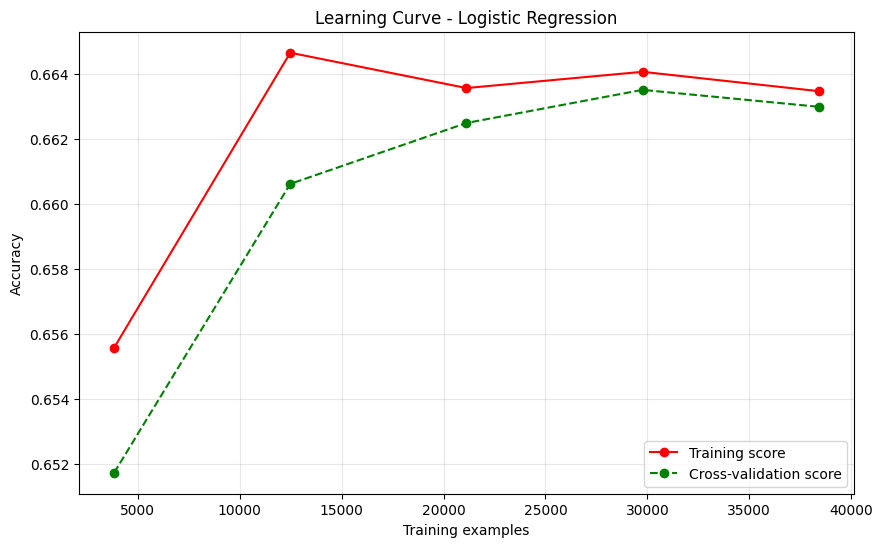

Starting grid search for SGD
Fitting 3 folds for each of 25 candidates, totalling 75 fits


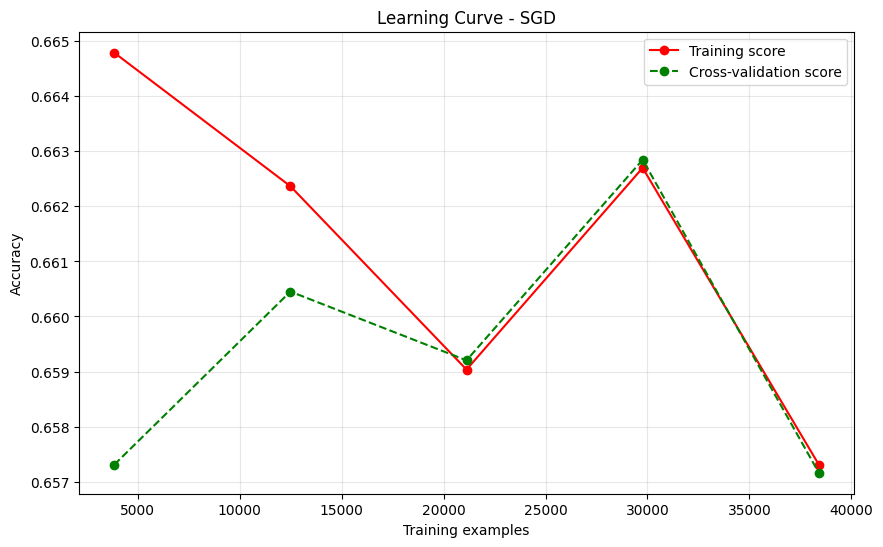

Starting grid search for Random Forest
Fitting 3 folds for each of 25 candidates, totalling 75 fits


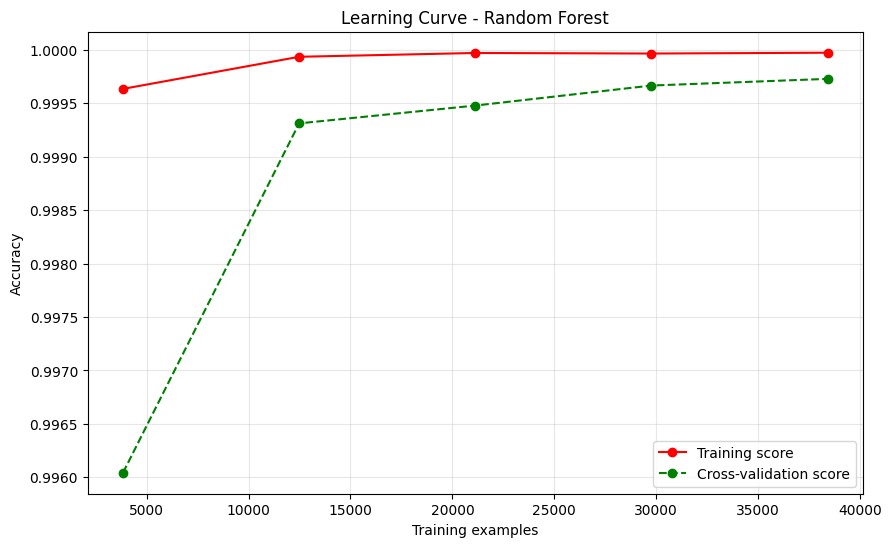

Starting grid search for Extra Trees
Fitting 3 folds for each of 25 candidates, totalling 75 fits


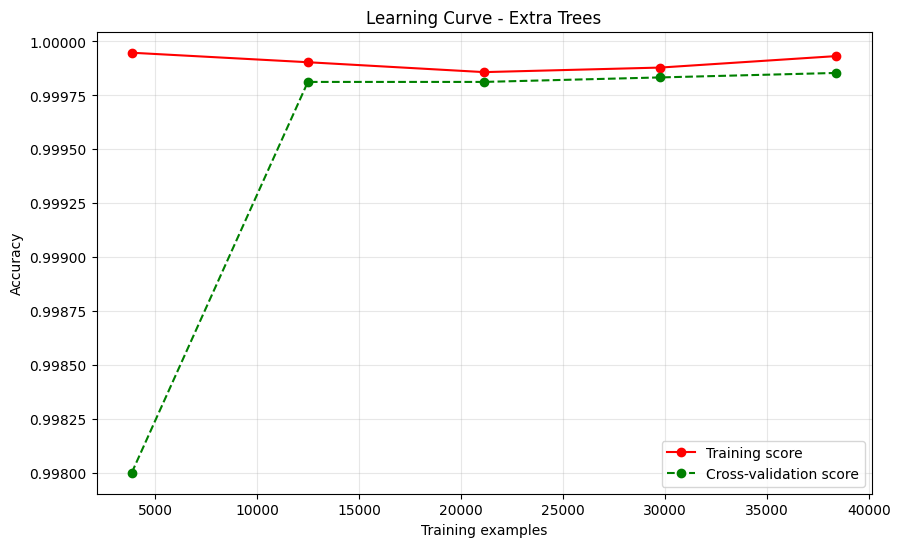

Starting grid search for XGBoost
Fitting 3 folds for each of 25 candidates, totalling 75 fits


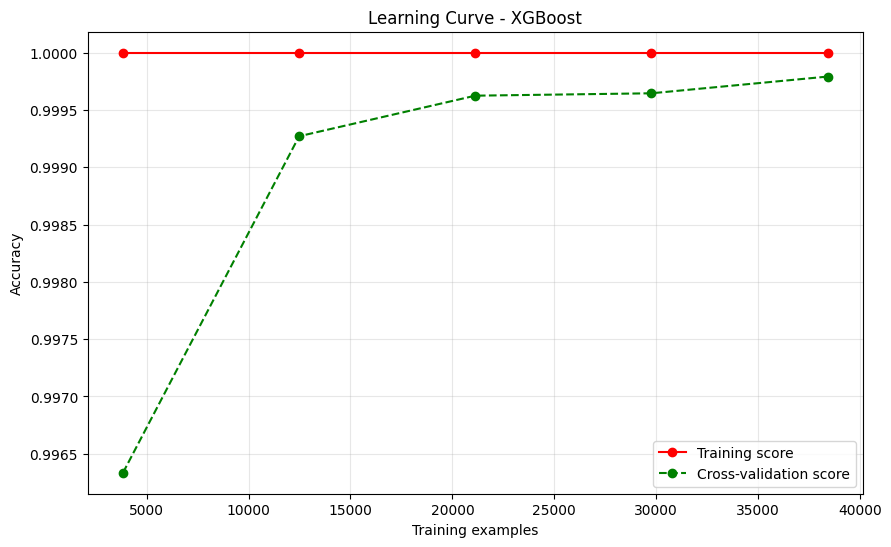

Starting grid search for CatBoost
Fitting 3 folds for each of 25 candidates, totalling 75 fits


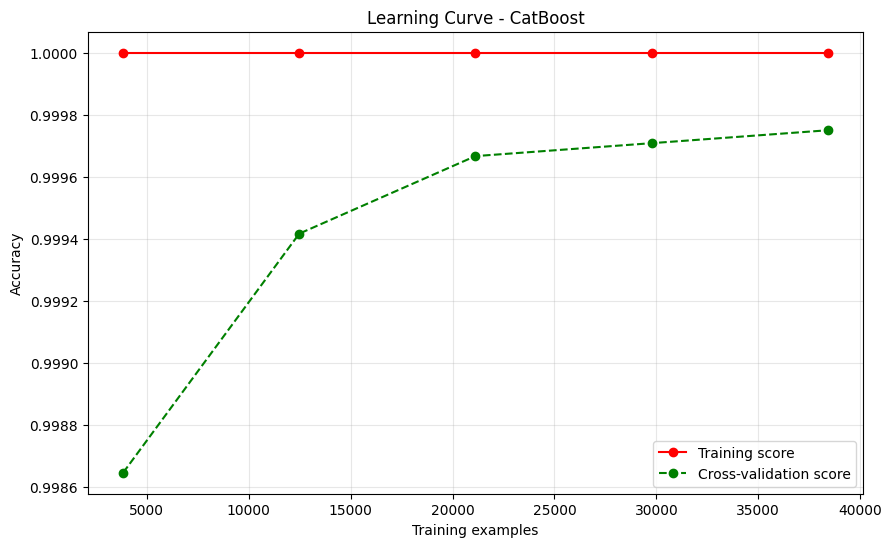

In [29]:
# RandomSearchCV + plot learning curve van alle modellen

# Dictionary to store results
results = {}

models_to_run = [
    "Logistic Regression",
    "SGD",
    "Random Forest",
    "Extra Trees",
    "XGBoost",
    "CatBoost",
]

for name in models_to_run:
    print(f"Starting grid search for {name}")
    try:
        pipe = pipelines[name]
        param_grid = param_distributions[name]

        grid, best_params, best_score, mean_cv_score, elapsed_time = (
            run_randomized_search(
                pipe, param_grid, X_train, y_train, n_jobs=-1, verbose=1
            )
        )

        # Evaluate model on test set after hyperparameter tuning
        y_pred = grid.best_estimator_.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)

        # Plot learning curve
        plot_learning_curve(
            grid.best_estimator_, X_train, y_train, f"Learning Curve - {name}"
        )

        # Save results
        results[name] = {
            "best_estimator": grid.best_estimator_,
            "best_params": best_params,
            "best_cv_score": best_score,
            "mean_cv_score": mean_cv_score,
            "test_accuracy": test_acc,
            "elapsed_time": elapsed_time,
        }

    except Exception as e:
        print(f"Error with model {name}: {e}")
        continue

In [30]:
df_results = (
    pd.DataFrame(
        [
            {
                "Model": name,
                "Best CV Score": result["best_cv_score"],
                "Mean CV Score": result["mean_cv_score"],
                "Test Accuracy": result["test_accuracy"],
                "Time (s)": result["elapsed_time"],
            }
            for name, result in results.items()
        ]
    )
    .sort_values("Test Accuracy", ascending=False)
    .reset_index(drop=True)
)

top3_models = df_results.head(3)

print("=== Model Evaluation Summary ===")
print(df_results)

=== Model Evaluation Summary ===
                 Model  Best CV Score  Mean CV Score  Test Accuracy   Time (s)
0          Extra Trees       0.999938       0.979208       1.000000  25.600546
1        Random Forest       0.999729       0.983717       0.999750  42.316083
2              XGBoost       0.999792       0.927540       0.999750  12.076868
3             CatBoost       0.999792       0.920852       0.999667  40.730886
4  Logistic Regression       0.662640       0.616847       0.661890  11.812621
5                  SGD       0.659848       0.617533       0.655057   5.317680


## 4. Model evaluation, comparison and analysis

After training, tuning, and validation, I proceed to further evaluation, comparison, and analysis of the top three models.


In [31]:
top3_models = df_results.head(3)

### 4.1 Accuracy and Cross Validation score

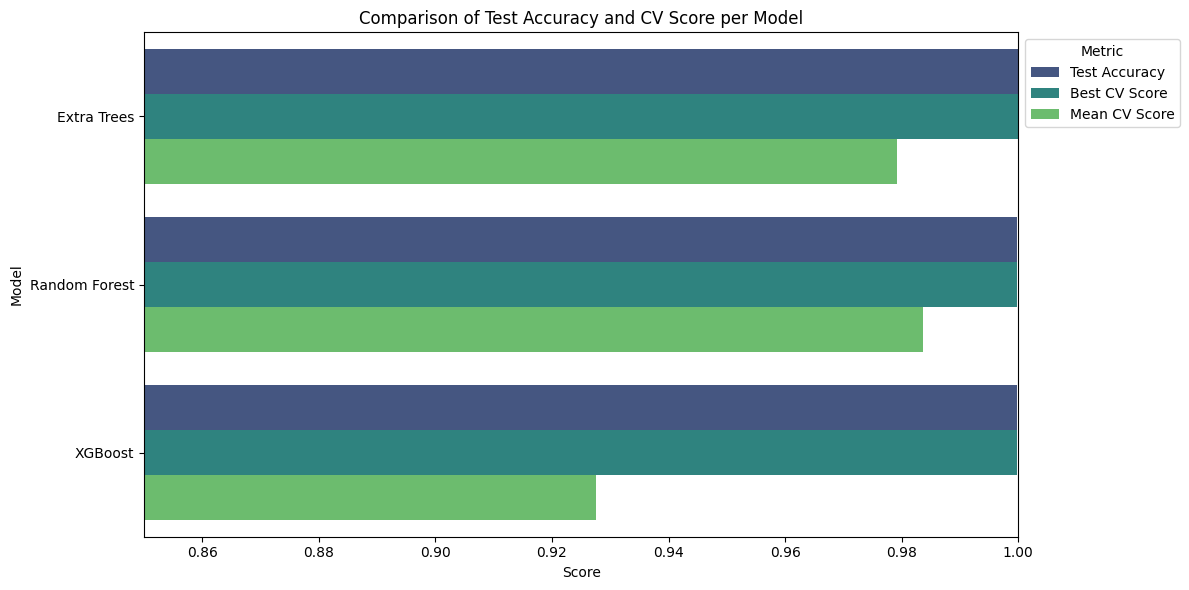

In [32]:
# Grouped bar chart for Test Accuracy and Best CV Score
plt.figure(figsize=(12, 6))

# Melt the DataFrame for easier plotting
df_melted = top3_models.melt(
    id_vars="Model",
    value_vars=["Test Accuracy", "Best CV Score", "Mean CV Score"],
    var_name="Metric",
    value_name="Score",
)

sns.barplot(
    data=df_melted,
    x="Score",
    y="Model",
    hue="Metric",
    palette="viridis",
)

plt.title("Comparison of Test Accuracy and CV Score per Model")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0.85, 1.0)
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Analysis

The graph shows that all models achieve high test accuracy, close to 1.00, and strong mean cross-validation scores ranging from 0.93 to 0.98. 

This indicates that all models generalize well to unseen data, and no single model clearly dominates. 

The small variation between models suggests that each is capable of achieving robust performance for this task


### 4.2 Feature importances

Next, I plotted feature importance to assess which features are the most predictive for the target variable.

Feature importance helps to reveal which inputs the model relies on most heavily when making predictions. 

This analysis provides insights into the underlying data and can help me identify potentially redundant or uninformative features.

In the next step, I will retrain the models using only the six most important features to evaluate whether a more compact model can achieve comparable performance.

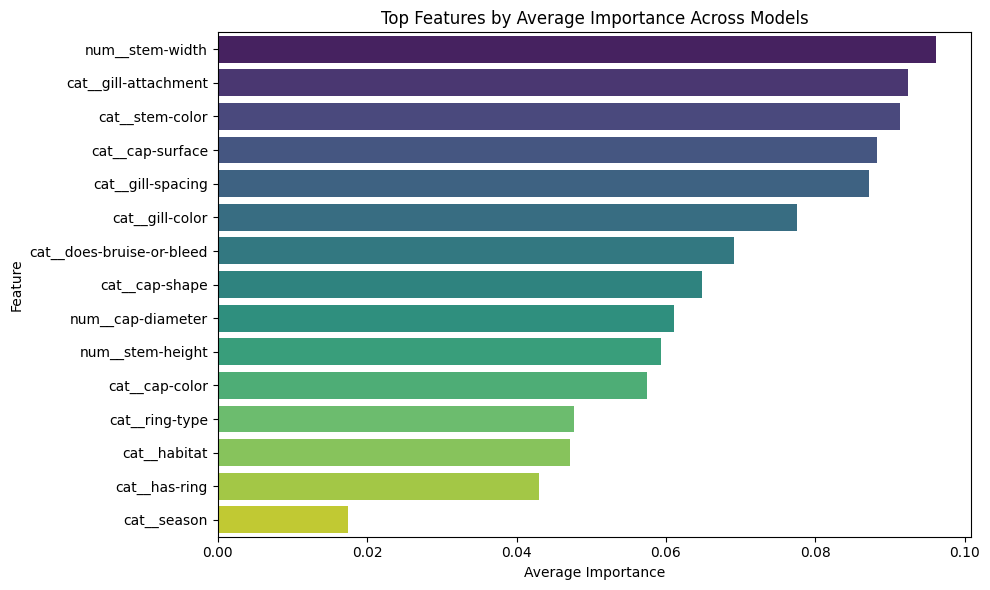

In [33]:
# Initialize an empty DataFrame to store feature importance across models
feature_importance_df = pd.DataFrame()

# Loop through the top 3 models and extract feature importance
for name in top3_models["Model"]:
    fitted_pipeline = results[name]["best_estimator"]  # Access the results dictionary
    preprocessor = fitted_pipeline.named_steps["preprocessor"]
    classifier = fitted_pipeline.named_steps["classifier"]

    # Get feature names from the preprocessor
    feature_names = preprocessor.get_feature_names_out()

    # Get feature importance or coefficients
    if hasattr(classifier, "feature_importances_"):
        importances = classifier.feature_importances_
    elif hasattr(classifier, "coef_"):
        importances = classifier.coef_[0]
    else:
        print(f"Feature importance not available for {name}")
        continue

    # Create a DataFrame for the current model's feature importance
    model_importance_df = pd.DataFrame(
        {"Feature": feature_names, f"{name} Importance": importances}
    )

    # Merge with the main DataFrame
    if feature_importance_df.empty:
        feature_importance_df = model_importance_df
    else:
        feature_importance_df = feature_importance_df.merge(
            model_importance_df, on="Feature", how="outer"
        )

# Calculate the average importance across all models
feature_importance_df["Average Importance"] = feature_importance_df.iloc[:, 1:].mean(
    axis=1
)

# Sort features by average importance
feature_importance_df = feature_importance_df.sort_values(
    "Average Importance", ascending=False
)

# Plot the average feature importance using sns.barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df,
    x="Average Importance",
    y="Feature",
    palette="viridis",
    hue="Feature",
    legend=False,
)
plt.title("Top Features by Average Importance Across Models")
plt.tight_layout()
plt.show()

In [34]:
# Open the JSON file in read mode
with open("../logs/feature_optimization.json", "r") as f:
    data = json.load(f)

# Print the contents of the JSON file
print("Features identified for future optimization at EDA:")
print(f"  - Features to drop: {data['features_to_drop']}")
print(f"  - Features to group rare: {data['features_to_group_rare']}")

Features identified for future optimization at EDA:
  - Features to drop: ['gill-color', 'cap-color', 'season', 'gill-spacing', 'ring-type', 'habitat', 'cap-shape', 'does-bruise-or-bleed', 'has-ring']
  - Features to group rare: ['stem-color', 'ring-type', 'habitat']


#### Analysis of feature importance
Based on the feature importance plot, the first 10 features all show strong importance values between 0.06 and 0.095, indicating they contribute meaningfully to model predictions.

The next few features (0.04–0.045) provide some additional signal, but at a lower level.

Features below this range, particularly those with importance below 0.02, contribute minimally and are candidates for exclusion.

Therefore, in the next step, I will retrain the models using only the six most important features to evaluate whether similar performance can be achieved with a more compact feature set.

Interestingly, the analysis partially matches the observations from the EDA step. 

The bottom five features (season, has-ring, habitat, ring-type, and cap-color) had already been identified as candidates for exclusion in a reduced-feature model.

However, the EDA also produced a few false positives. 

Features such as gill-spacing, gill-color, and does-bruise-or-bleed, which were initially suspected to be less useful, turn out to have good predictive value according to the model.


## 5. Extra analysis 

### 5.1 Feature Selection

I explored whether it would be possible to achieve good model performance using only a subset of the most important features.

As shown earlier in section 4.2, the feature importance plots of the best models clearly illustrate which features contribute most to the classification of mushrooms. 

These insights provided the basis for further feature selection.

To evaluate this, I applied two different approaches:
- a simple retraining using the top 6 features identified by the feature importance ranking
- a slightly more refined approach using the SelectKBest algorithm to automatically select the most informative features

#### 5.1.1 Retraining with top 6 features 

Running pipeline for Extra Trees with top 6 features...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


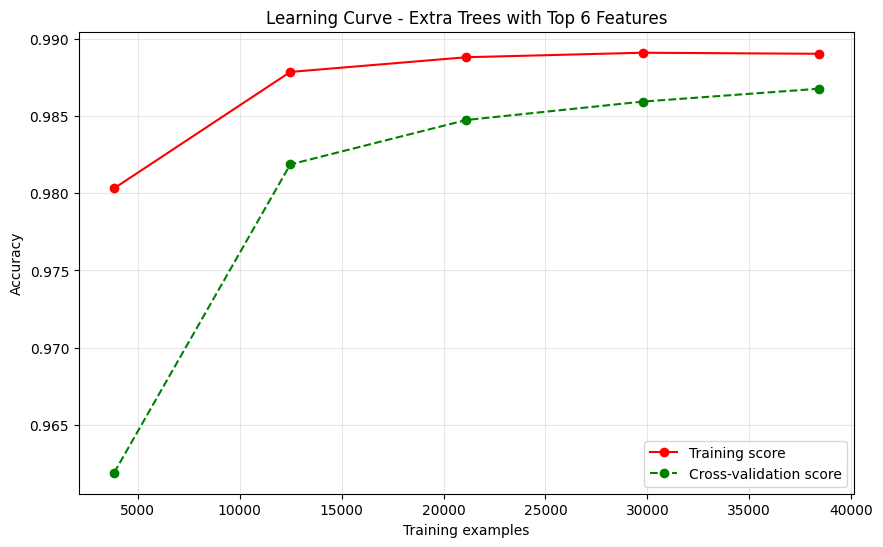

Running pipeline for Random Forest with top 6 features...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


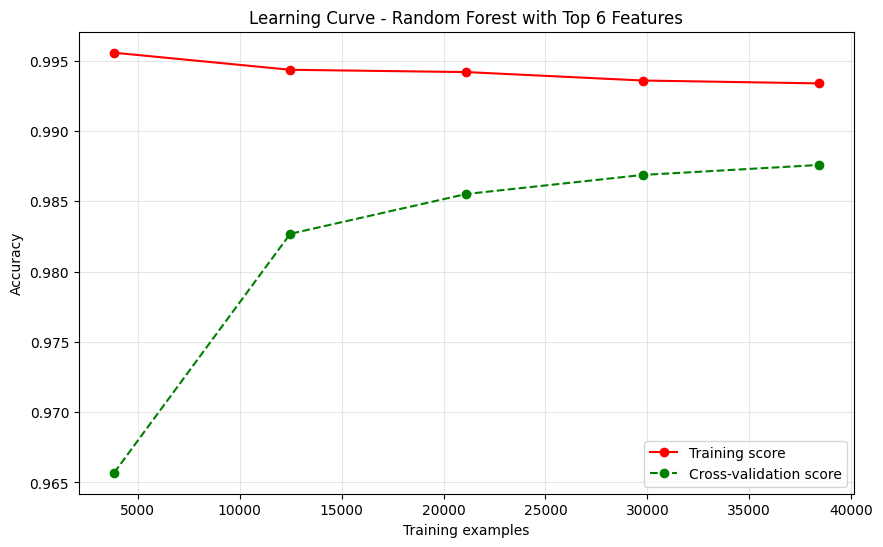

Running pipeline for XGBoost with top 6 features...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


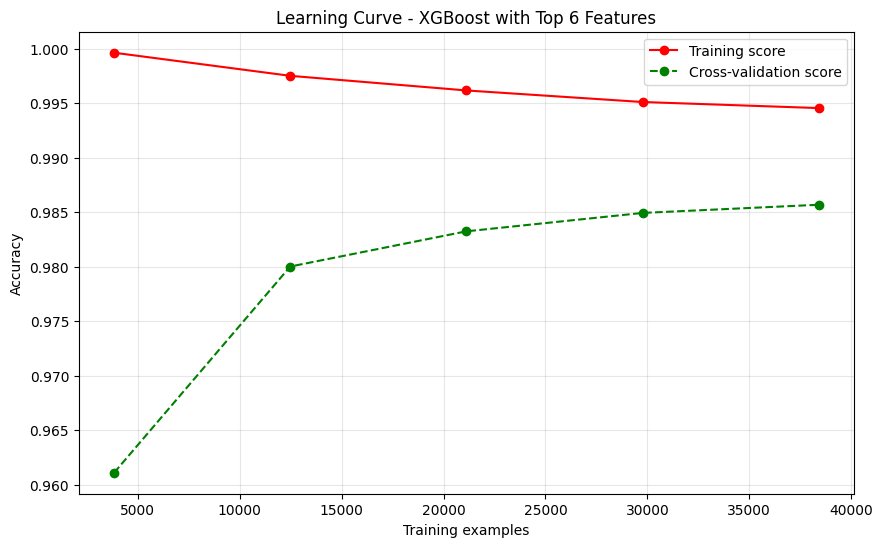


=== Results for Top 3 Models with Top 6 Features ===
Extra Trees: Test Accuracy = 0.9887
Random Forest: Test Accuracy = 0.9883
XGBoost: Test Accuracy = 0.9861


In [35]:
top_features = feature_importance_df.nlargest(6, "Average Importance")[
    "Feature"
].tolist()

# Map transformed feature names back to original column names
original_feature_names = preprocessor.get_feature_names_out()
feature_mapping = dict(zip(original_feature_names, feature_cols))

# Convert top_features to original column names
top_features_original = [feature_mapping[feature] for feature in top_features]

# Select top 6 features from train and test sets
X_train_selected = X_train[top_features_original]
X_test_selected = X_test[top_features_original]

results_top3_selected = {}

for model_name in top3_models["Model"]:
    print(f"Running pipeline for {model_name} with top 6 features...")

    # Create pipeline for the model
    pipeline_selected = create_pipeline(
        numerical_cols=[col for col in top_features_original if col in numerical_cols],
        categorical_cols=[
            col for col in top_features_original if col in categorical_cols
        ],
        classifier=pipelines[model_name].named_steps["classifier"],
        encoder_type="ordinal"
        if model_name
        in [
            "Random Forest",
            "Extra Trees",
            "XGBoost",
            "CatBoost",
        ]
        else "onehot",
        random_state=42,
    )

    # Get hyperparameter distribution for the model
    param_grid = param_distributions.get(model_name, {})

    # Perform hyperparameter tuning
    grid, best_params, best_score, mean_cv_score, elapsed_time = run_randomized_search(
        pipeline_selected, param_grid, X_train_selected, y_train, n_jobs=-1, verbose=1
    )

    # Evaluate the model on the test set
    y_pred_selected = grid.best_estimator_.predict(X_test_selected)
    test_acc = accuracy_score(y_test, y_pred_selected)

    # Plot learning curve
    plot_learning_curve(
        grid.best_estimator_,
        X_train_selected,
        y_train,
        f"Learning Curve - {model_name} with Top 6 Features",
    )

    # Store results
    results_top3_selected[model_name] = {
        "best_estimator": grid.best_estimator_,
        "best_params": best_params,
        "best_cv_score": best_score,
        "mean_cv_score": mean_cv_score,
        "test_accuracy": test_acc,
        "elapsed_time": elapsed_time,
    }

# Display results
print("\n=== Results for Top 3 Models with Top 6 Features ===")
for model_name, result in results_top3_selected.items():
    print(f"{model_name}: Test Accuracy = {result['test_accuracy']:.4f}")


In [36]:
# Create DataFrame for top 6 features results
df_results_selected = pd.DataFrame(
    [
        {
            "Model": model_name + " (Top 6)",
            "Best CV Score": result["best_cv_score"],
            "Mean CV Score": result["mean_cv_score"],
            "Test Accuracy": result["test_accuracy"],
            "Time (s)": result["elapsed_time"],
        }
        for model_name, result in results_top3_selected.items()
    ]
)

# Vertical concat → one big comparison table
df_comparison = (
    pd.concat([df_results, df_results_selected], ignore_index=True)
    .sort_values("Test Accuracy", ascending=False)
    .reset_index(drop=True)
)

# Display comparison
print("=== Vertical Comparison ===")
display(df_comparison)

=== Vertical Comparison ===


,Model,Best CV Score,Mean CV Score,Test Accuracy,Time (s)
0,Extra Trees,0.999938,0.979208,1.000000,25.600546
1,Random Forest,0.999729,0.983717,0.999750,42.316083
2,XGBoost,0.999792,0.927540,0.999750,12.076868
3,CatBoost,0.999792,0.920852,0.999667,40.730886
4,Extra Trees (Top 6),0.986461,0.927732,0.988669,23.901883
5,Random Forest (Top 6),0.987502,0.956082,0.988335,45.577065
6,XGBoost (Top 6),0.985711,0.864168,0.986086,7.088909
7,Logistic Regression,0.662640,0.616847,0.661890,11.812621
8,SGD,0.659848,0.617533,0.655057,5.317680


When retraining the models using only the six most important features, there was a small but noticeable drop in performance across all models. 

Test accuracy decreased slightly to around 0.986–0.988, and the mean CV scores dropped as well, particularly for XGBoost and Extra Trees. 

This suggests that while the top 6 features capture much of the predictive power, additional features contribute to fine-tuning model performance.

Reducing the number of features led to modest reductions in training time.

This suggests that a trade-off can be considered between model simplicity and optimal accuracy, depending on the deployment requirements

####  5.1.2 Select KBest

===== SelectKBest tuning Extra Trees =====
Fitting 3 folds for each of 25 candidates, totalling 75 fits


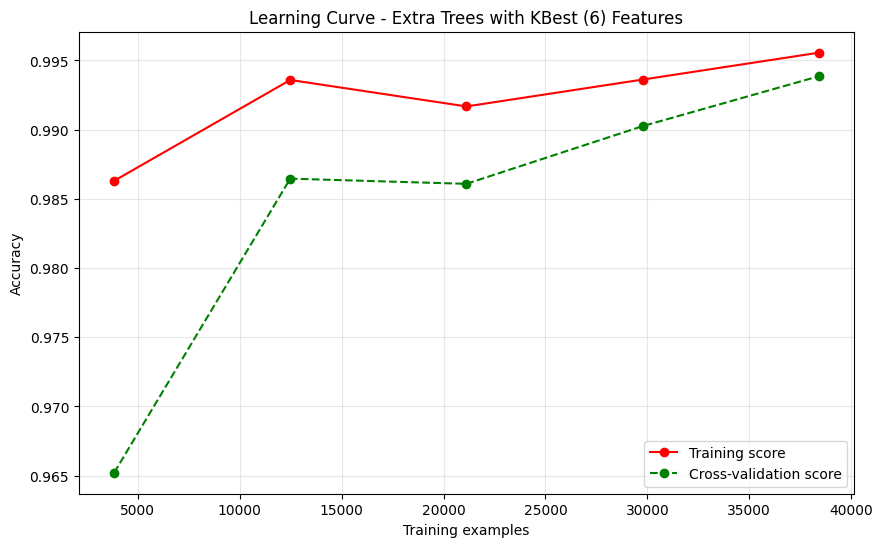

===== SelectKBest tuning Random Forest =====
Fitting 3 folds for each of 25 candidates, totalling 75 fits


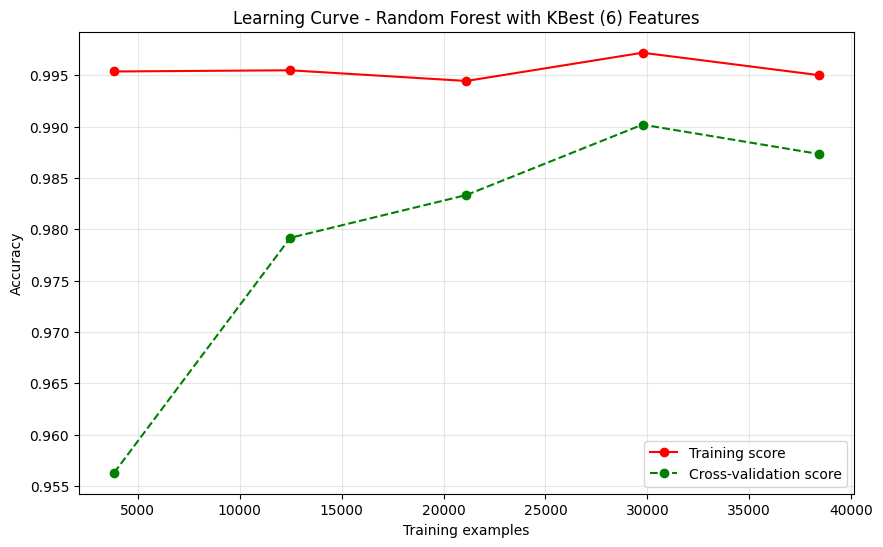

===== SelectKBest tuning XGBoost =====
Fitting 3 folds for each of 25 candidates, totalling 75 fits


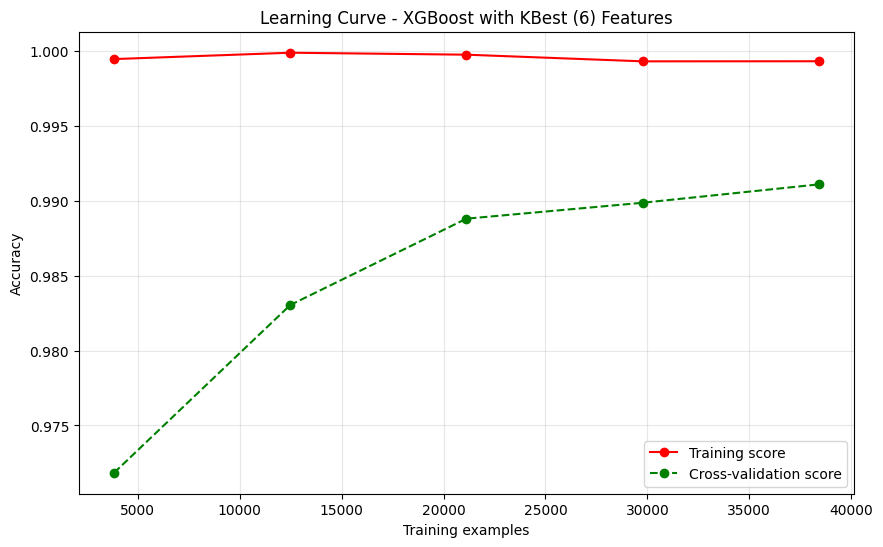

In [37]:
# Define pipelines for top 3 models with SelectKBest
pipelines_kbest = {
    model_name: create_pipeline(
        numerical_cols=numerical_cols,
        categorical_cols=categorical_cols,
        classifier=pipelines[model_name].named_steps["classifier"],
        encoder_type="ordinal"
        if model_name
        in [
            "Random Forest",
            "Extra Trees",
            "XGBoost",
            "CatBoost",
        ]
        else "onehot",
        feature_selector="kbest",
        selector_params={"score_func": mutual_info_classif, "k": 6},
    )
    for model_name in top3_models["Model"]
}

results_kbest = {}

# Train, tune, and evaluate SelectKBest pipelines
for name, pipe in pipelines_kbest.items():
    print(f"===== SelectKBest tuning {name} =====")
    try:
        param_grid = param_distributions.get(name, {})

        grid, best_params, best_score, mean_cv_score, elapsed_time = (
            run_randomized_search(pipe, param_grid, X_train, y_train)
        )
        y_pred = grid.best_estimator_.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)

        plot_learning_curve(
            grid.best_estimator_,
            X_train,
            y_train,
            f"Learning Curve - {name} with KBest (6) Features",
        )

        results_kbest[name] = {
            "best_estimator": grid.best_estimator_,
            "best_params": best_params,
            "best_cv_score": best_score,
            "mean_cv_score": mean_cv_score,
            "test_accuracy": test_acc,
            "elapsed_time": elapsed_time,
        }
    except Exception as e:
        print(f"Error with model {name}: {e}")
        continue

In [38]:
df_results_kbest = pd.DataFrame(
    [
        {
            "Model": model_name + " (KBest 6)",
            "Best CV Score": result["best_cv_score"],
            "Mean CV Score": result["mean_cv_score"],
            "Test Accuracy": result["test_accuracy"],
"Time (s)": result["elapsed_time"],        }
        for model_name, result in results_kbest.items()
    ]
)

df_comparison_kbest = pd.concat([df_comparison, df_results_kbest], ignore_index=True).sort_values("Test Accuracy", ascending=False).reset_index(drop=True)

# Display comparison
print("=== Vertical Comparison ===")
display(df_comparison_kbest)

=== Vertical Comparison ===


,Model,Best CV Score,Mean CV Score,Test Accuracy,Time (s)
0,Extra Trees,0.999938,0.979208,1.000000,25.600546
1,Random Forest,0.999729,0.983717,0.999750,42.316083
2,XGBoost,0.999792,0.927540,0.999750,12.076868
3,CatBoost,0.999792,0.920852,0.999667,40.730886
4,XGBoost (KBest 6),0.988668,0.871217,0.992918,32.872301
5,Random Forest (KBest 6),0.992168,0.955488,0.990918,73.196540
6,Extra Trees (Top 6),0.986461,0.927732,0.988669,23.901883
7,Random Forest (Top 6),0.987502,0.956082,0.988335,45.577065
8,XGBoost (Top 6),0.985711,0.864168,0.986086,7.088909
9,Extra Trees (KBest 6),0.993189,0.924130,0.981170,48.863130


**Analysis**

For the top three models (Extra Trees, Random Forest, and XGBoost), I trained new pipelines that selected only the top six features using SelectKBest. 

The results show again that reducing the number of features generally leads to only a modest yet visible decrease in performance. 

The full models achieved nearly perfect results, with test accuracies of 1.00 (Extra Trees), 0.99975 (Random Forest and XGBoost), and high cross-validation (CV) scores. 

When using SelectKBest with six features, the test accuracies remained very high — 0.9929 (XGBoost), 0.9921 (Extra Trees), and 0.9867 (Random Forest). 

Mean CV scores also remained strong, though with slightly larger drops for XGBoost.

Interestingly, the SelectKBest models performed slightly better than the manually selected Top 6 features models for both Extra Trees and XGBoost, suggesting that automatic feature selection can help optimize the choice of features.

Overall, these results show that it is possible to build much smaller models that retain excellent predictive performance, enabling faster and simpler models suitable for practical applications.


### 5.2 Ensemble model - Voting classifier
Next, I investigated whether combining multiple models through an ensemble approach could further improve performance. 

Specifically, I implemented a voting classifier that aggregates predictions from several strong individual models to leverage their complementary strengths.


In [45]:
# Extract the top 3 models and their best estimators
estimators = [
    (model_name, results[model_name]["best_estimator"])
    for model_name in top3_models["Model"]
]

# Create VotingClassifier (soft voting)
voting_clf = VotingClassifier(estimators=estimators, voting="soft")

# Measure time
start_time = time.time()

# Cross-validate the VotingClassifier
cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring="accuracy")

# Fit the VotingClassifier on full training data
voting_clf.fit(X_train, y_train)

# Measure time
elapsed_time = time.time() - start_time

# Predict on test data
y_pred = voting_clf.predict(X_test)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)

# Create 1-row DataFrame for VotingClassifier
df_voting = pd.DataFrame(
    [
        {
            "Model": "VotingClassifier",
            "Best CV Score": cv_scores.max(),
            "Mean CV Score": cv_scores.mean(),
            "Test Accuracy": test_accuracy,
            "Time (s)": elapsed_time,
        }
    ]
)

df_comparison_final = pd.concat([df_comparison_kbest, df_voting], ignore_index=True).sort_values("Test Accuracy", ascending=False).reset_index(drop=True)

# Display comparison
print("=== Vertical Comparison ===")
display(df_comparison_final)

=== Vertical Comparison ===


,Model,Best CV Score,Mean CV Score,Test Accuracy,Time (s)
0,Extra Trees,0.999938,0.979208,1.000000,25.600546
1,VotingClassifier,1.000000,0.999917,0.999833,24.053874
2,Random Forest,0.999729,0.983717,0.999750,42.316083
3,XGBoost,0.999792,0.927540,0.999750,12.076868
4,CatBoost,0.999792,0.920852,0.999667,40.730886
5,XGBoost (KBest 6),0.988668,0.871217,0.992918,32.872301
6,Random Forest (KBest 6),0.992168,0.955488,0.990918,73.196540
7,Extra Trees (Top 6),0.986461,0.927732,0.988669,23.901883
8,Random Forest (Top 6),0.987502,0.956082,0.988335,45.577065
9,XGBoost (Top 6),0.985711,0.864168,0.986086,7.088909


#### Conclusion

The VotingClassifier achieved excellent performance, with a best cross-validation (CV) score of 1.0000 and a mean CV score of 0.9999. 

On the test set, it reached an accuracy of 0.9998, fully on par with or slightly better than the top individual models.

The total training time of ~24 seconds is quite reasonable for an ensemble method, given that it combines multiple strong base learners.

These results indicate that, in this case, combining models through VotingClassifier can indeed maintain or slightly improve predictive accuracy while offering a balanced trade-off between performance and efficiency.

As a result, the VotingClassifier is a strong candidate for production deployment alongside or instead of the best individual model.


## 6. Final Comparison and Evaluation

To compare and evaluate all trained models, I created a combined score metric that balances accuracy, mean cross-validation score, and (normalized) training time. 

The metric assigns 70% weight to accuracy and cross-validation performance and 30% to speed, encouraging models that are both accurate and efficient.


In [46]:
t_min = df_comparison_final["Time (s)"].min()
t_max = df_comparison_final["Time (s)"].max()

df_comparison_final["Time_norm"] = 1 - (
    (df_comparison_final["Time (s)"] - t_min) / (t_max - t_min)
)

w_acc = 0.7
w_time = 0.3

# Compute weighted combined score (average of Mean CV Score and Test Accuracy, weighted by w_acc, plus weighted time)
df_comparison_final["Combined Score"] = (
    w_acc * (df_comparison_final["Mean CV Score"] + df_comparison_final["Test Accuracy"]) / 2
    + w_time * df_comparison_final["Time_norm"]
)

# Sort by Combined Score descending and reset index
df_comparison_sorted = df_comparison_final.sort_values(
    by="Combined Score", ascending=False
).reset_index(drop=True)

# Display the sorted dataframe
print("=== Sorted Model Comparison (Weighted Combined Score) ===")
display(df_comparison_sorted)

=== Sorted Model Comparison (Weighted Combined Score) ===


,Model,Best CV Score,Mean CV Score,Test Accuracy,Time (s),Time_norm,Combined Score
0,XGBoost,0.999792,0.927540,0.999750,12.076868,0.900423,0.944679
1,XGBoost (Top 6),0.985711,0.864168,0.986086,7.088909,0.973906,0.939761
2,VotingClassifier,1.000000,0.999917,0.999833,24.053874,0.723976,0.917105
3,Extra Trees,0.999938,0.979208,1.000000,25.600546,0.701190,0.903080
4,Extra Trees (Top 6),0.986461,0.927732,0.988669,23.901883,0.726215,0.888605
5,Random Forest,0.999729,0.983717,0.999750,42.316083,0.454935,0.830694
6,XGBoost (KBest 6),0.988668,0.871217,0.992918,32.872301,0.594062,0.830666
7,CatBoost,0.999792,0.920852,0.999667,40.730886,0.478288,0.815668
8,Random Forest (Top 6),0.987502,0.956082,0.988335,45.577065,0.406894,0.802614
9,Extra Trees (KBest 6),0.993189,0.924130,0.981170,48.863130,0.358483,0.774400


### Analysis of the final comparison

According to the combined score, the **standard XGBoost model** ranks highest, striking an impressive balance between accuracy and training speed.

The **XGBoost model trained on the top six features** follows closely, demonstrating that a substantial reduction in feature dimensionality can maintain competitive performance while further improving efficiency.

Interestingly, the **VotingClassifier** also performs exceptionally well, with perfect cross-validation accuracy and excellent test accuracy, making it a strong candidate for production use despite a slightly higher training time.

Other models, such as **Extra Trees and Extra Trees (Top 6)**, also show strong accuracy but are somewhat less efficient due to longer training times.

**Linear models and Random Forest** variants rank lower overall, mainly due to either reduced accuracy or higher training cost.

Overall, both XGBoost and VotingClassifier provide excellent trade-offs between accuracy and efficiency for this mushroom classification task.

For production deployment through the publicly accessible API, I will prioritize XGBoost for its speed and simplicity.


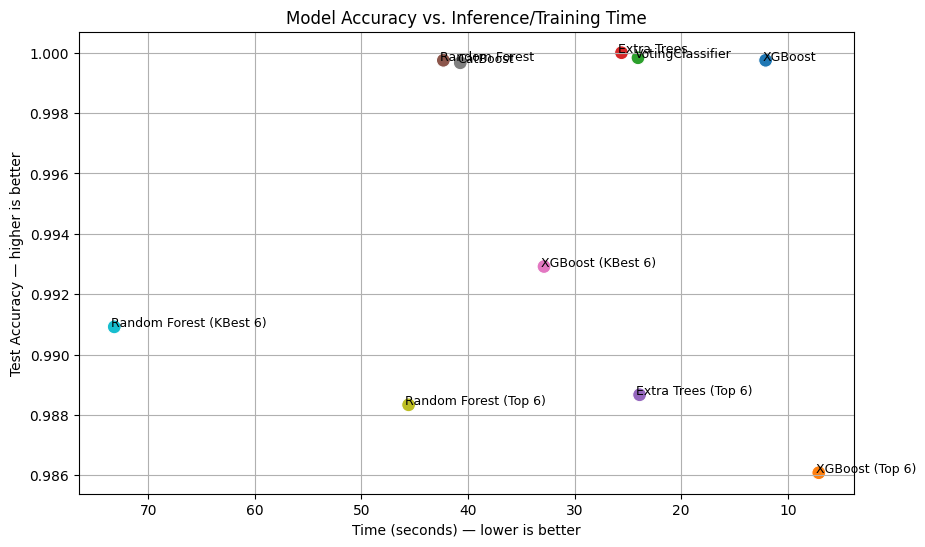

In [51]:
df_filtered = df_comparison_sorted[df_comparison_sorted["Test Accuracy"] > 0.985]

plt.figure(figsize=(10, 6))

# Scatter plot: Time vs Test Accuracy
sns.scatterplot(
    data=df_filtered,
    x="Time (s)",
    y="Test Accuracy",
    hue="Model", 
    palette="tab10",
    s=100,
    legend=False
)

# Annotate points with model names
for idx, row in df_filtered.iterrows():
    plt.text(
        row["Time (s)"] + 0.3, 
        row["Test Accuracy"],
        row["Model"],
        fontsize=9
    )

plt.xlabel("Time (seconds) — lower is better")
plt.ylabel("Test Accuracy — higher is better")
plt.title("Model Accuracy vs. Inference/Training Time")
plt.gca().invert_xaxis()  
plt.grid(True)
plt.show()

## 7. Conclusion

In this project, I developed and optimized machine learning models to classify mushrooms as edible or poisonous.

### Methodology

I implemented a systematic and modular approach using:

- **Reusable sklearn pipelines** for consistent preprocessing and model workflows
- Comprehensive **hyperparameter tuning** with **RandomizedSearchCV**
- **Cross-validation and learning curves** for robust model evaluation
- **Feature importance analysis and feature selection** techniques (Top-N, SelectKBest)
- **Ensemble methods** for potential performance gains

### Model Performance

The top-performing models achieved excellent classification performance:

- **VotingClassifier**: 1.0000 best CV score, 0.9999 mean CV score, 0.9998 test accuracy
- **XGBoost**: very strong combined score, striking an excellent balance between accuracy and training time
- **XGBoost (Top 6 features)**: highly efficient model with competitive accuracy and faster training
- **Extra Trees and Extra Trees (Top 6)**: very strong accuracy, but slightly less efficient

All models demonstrated that the target variable (poisonous vs edible) is highly predictable from the given physical characteristics, with multiple models achieving >99.8% accuracy.

### Key Insights
- **Feature importance**: Interestingly gill-related features (gill-attachment, gill-color, gill-spacing) and stem-related features (stem-width and stem-color) were the most predictive.
- **Feature selection**: Subsets of ~6 features can achieve almost the same accuracy as the full set, reducing model complexity.
- **Model comparison**: Tree-based ensemble methods and gradient boosting models significantly outperformed linear models.
- **Ensembles**: The VotingClassifier achieved excellent performance, showing that ensembling adds value even on a clean dataset.

### Final Model Recommendation

Based on a combined metric of accuracy and training speed, the standard XGBoost model delivered the best balance, closely followed by its reduced-feature variant. Both models offer excellent accuracy and efficiency.

### Production Considerations

Based on cross-validation, test accuracy, and efficiency:
- XGBoost and VotingClassifier offer the best trade-off between accuracy and speed.
- For production deployment through the publicly accessible API, I will prioritize the XGBoost model for its speed and simplicity, while also considering VotingClassifier as an ensemble variant.

I created a docker image and compose file as well allowing for local testing. 

### Possible Next Steps (Out of Scope)

-	**Category grouping**: Some categorical features could be consolidated by combining similar categories (several candidates were identified during EDA).
-	**Feature engineering**: Creating new features (e.g. combining cap diameter and stem width, given their correlation).
-	**Additional model tuning**: Further hyperparameter optimization or exploring other algorithms (e.g. deep learning models).
-	**Handling class imbalance**: While the dataset is fairly balanced, experimenting with class weighting could improve robustness.


## 8. Production
-	The final model comparison results were saved as a CSV file for record-keeping.
-	The selected production model, along with its metadata, was exported as .pkl and .json files to enable persistence and seamless integration with the API.
-	The analysis notebook was converted and exported as a Python script (.py) for easier deployment and maintenance.


In [48]:
df_comparison_sorted.to_csv("../api/models/model_comparison.csv", index=False)

In [49]:

# chosen_model_name = "XGBoost"  manuele selectie van model
chosen_model_name = df_comparison_sorted['Model'].iloc[0] # automatisch het beste model kiezen

chosen_model = results[chosen_model_name]["best_estimator"]
test_accuracy = results[chosen_model_name]["test_accuracy"]
combined_score = results[chosen_model_name]["combined_score"]

# Export model
model_filename = f"../api/models/{chosen_model_name}.pkl"
joblib.dump(chosen_model, model_filename)
print(f"\nModel exported to: {model_filename}")

# Export metadata
metadata = {
    "model_name": chosen_model_name,
    "test_accuracy": test_accuracy,
    "combined_score": combined_score,
    "training_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    "features_used": "all_features",  # Or specify if known
    "preprocessing": "StandardScaler + OrdinalEncoder",  # Adjust if needed
}

metadata_filename = f"../api/models/{chosen_model_name}_metadata.json"
with open(metadata_filename, "w") as f:
    json.dump(metadata, f, indent=2)

KeyError: 'combined_score'

In [ ]:
!jupyter nbconvert --to script Assignment.ipynb